In [ ]:
!pip install git+https://github.com/chaithyagr/fastmri-reproducible-benchmark@patch-1 silence-tensorflow

# Non-Cartesian MRI reconstruction with the NCPDNet

If you are not familiar with the basics of MRI reconstruction, please first take a look at the [introduction notebook](mri_reconstruction_intro.ipynb).

In this notebook, we will illustrate the use of the NCPDNet [[1]](#ref1) for non-Cartesian MRI reconstruction.
At NeuroSpin, we have been developing for some time non-Cartesian trajectories to optimize the MRI acquisition, like SPARKLING [[2]](#ref2) and more recently learned trajectories [[3]](#ref3).
The ability to use non-Cartesian trajectories enables a better covering of the k-space (the Fourier space of the image to reconstruct), and thus a more efficient undersampling.
This however makes the reconstruction process more difficult, and we will see here how to use the NCPDNet to alleviate this problem.

One important aspect is that the measurement operator $F_{\Omega}$ is not a masked Fourier transform, but a nonuniform Fourier transform.
This operator will be approximated by a nonuniform fast Fourier Transform (NUFFT).

[1] <a id='ref1'></a> Ramzi Z., Starck J.-L., Chaithya G R, and Ciuciu P., “NC-PDNet: a Density-Compensated Unrolled Network for 2D and 3D non-Cartesian MRI Reconstruction,” 2021. https://hal.inria.fr/hal-03188997/document

[2] <a id='ref2'></a> Lazarus C. et al., “SPARKLING: variable-density k-space filling curves for accelerated T 2 * -weighted MRI,” Magn. Reson. Med., no. December 2018, pp. 1–19, 2019. https://hal.inria.fr/hal-02361265

[3] <a id='ref3'></a> Chaithya G R, Ramzi Z., and Ciuciu P., “Hybrid learning of Non-Cartesian k-space trajectory and MR image reconstruction networks.” 2021 https://arxiv.org/abs/2110.12691

Small note on requirements: run [postBuild](../postBuild) (i.e. `bash postBuild`) to install `silence-tensorflow` if not running this notebook in binder.

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import io
import requests

from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np
import silence_tensorflow.auto
import tensorflow as tf
from tfkbnufft.kbnufft import KbNufftModule

from fastmri_recon.data.datasets.preprocessing import non_cartesian_from_kspace_to_nc_kspace_and_traj
from fastmri_recon.data.utils.crop import crop_center
from fastmri_recon.evaluate.metrics.np_metrics import psnr, ssim
from fastmri_recon.models.subclassed_models.ncpdnet import NCPDNet
from fastmri_recon.models.utils.fourier import AdjNFFT

In [11]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 6

In [12]:
tf.random.set_seed(0)
np.random.seed(0)

## Outline

In this notebook, we will [load the data](#data), [retrospectively undersample it](#undersample) with a non-Cartesian sampling scheme, and then reconstruct it using the [NCPDNet](#ncpdnet).

## Data handling <a id='data'></a>

We use the same data as in the [introduction notebook](mri_reconstruction_intro.ipynb), from the fastMRI dataset [[4]](#ref4).

[4] <a id='ref4'></a> Zbontar, J., Knoll, F., Sriram, A., Muckley, M. J., Bruno, M., Defazio, A., … Lui, Y. W. (n.d.). fastMRI: An Open Dataset and Benchmarks for Accelerated MRI. Retrieved from https://arxiv.org/pdf/1811.08839.pdf

In [13]:
image = np.load(io.BytesIO(requests.get('https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/raw/master/examples/gt_image.npy').content), allow_pickle=True)
kspace = np.load(io.BytesIO(requests.get('https://github.com/zaccharieramzi/fastmri-reproducible-benchmark/raw/master/examples/gt_kspace.npy').content), allow_pickle=True)

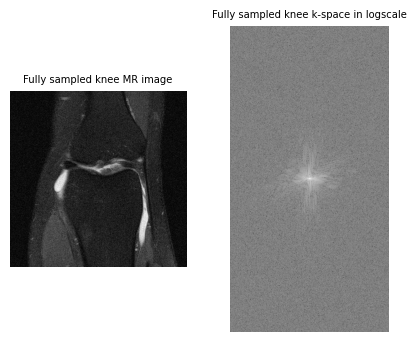

In [14]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee MR image')
axs[1].imshow(np.log(np.abs(kspace[..., 0])))
axs[1].set_title('Fully sampled knee k-space in logscale')
for i in [0, 1]:
    axs[i].axis('off');

## Retrospective non-Cartesian undersampling <a id='undersample'></a>

We will use a radial trajectory with an acceleration factor of 4 for the non-Cartesian retrospective undersampling.

In [15]:
image_size = (640, 400)
nufft_ob = KbNufftModule(
    im_size=image_size,
    grid_size=None,
    norm='ortho',
)

In [16]:
(nc_kspaces_channeled, traj, extra_args), _ = non_cartesian_from_kspace_to_nc_kspace_and_traj(
    nufft_ob,
    image_size,
    acq_type='radial',
    scale_factor=1e6,
    compute_dcomp=True,
    gridding=False,
    af=4,
)(
    image[None, ..., 0],
    kspace[None, ..., 0],
)

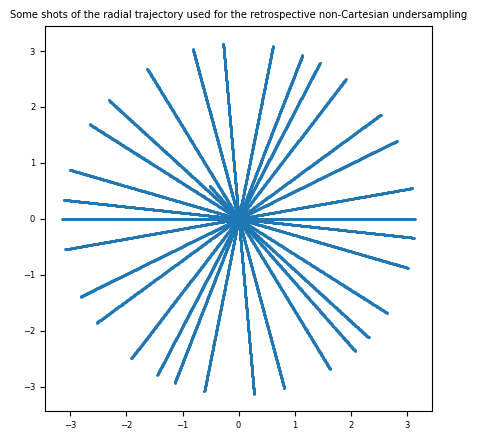

In [17]:
plt.figure()
plt.scatter(traj[0, 0, :10000], traj[0, 1, :10000], s=1)
plt.title('Some shots of the radial trajectory used for the retrospective non-Cartesian undersampling');

If one applies directly the adjoint of the non-uniform Fourier transform, even if it is density compensated, as prescribed by Pipe et al. [[5]](#ref5), the reconstruction will suffer from artifacts.

[5] <a id='ref5'></a> Pipe, J. G.  and Menon P., “Sampling density compensation in MRI: Rationale and an iterative numerical solution,” Magn. Reson. Med., vol. 41, no. 1, pp. 179–186, 1999. https://pubmed.ncbi.nlm.nih.gov/10025627/

In [18]:
adj_op = AdjNFFT(
    im_size=image_size,
    multicoil=False,
    density_compensation=True,
    grad_traj=False,
)

adj_dcomp_image = adj_op([nc_kspaces_channeled, traj, *extra_args])
adj_dcomp_image = crop_center(adj_dcomp_image[0, ..., 0], 320)

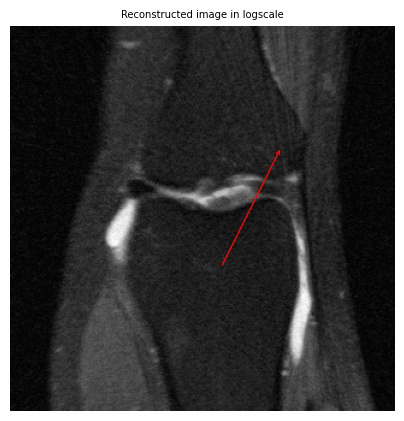

In [19]:
plt.figure()
plt.imshow(np.abs(adj_dcomp_image))
plt.title('Reconstructed image in logscale')
plt.axis('off')
plt.annotate("", xy=(225, 100), xytext=(175, 200),
            arrowprops=dict(arrowstyle="->", color='red'));

The red arrow in the image shows the radial artifacts.

In [20]:
print('PSNR of the density-compensated adjoint reconstructed image:', psnr(image, np.abs(adj_dcomp_image)[..., None]/1e6))

PSNR of the density-compensated adjoint reconstructed image: 25.630301469799996


In [21]:
print('SSIM of the density-compensated adjoint reconstructed image:', ssim(image[None, ..., 0], np.abs(adj_dcomp_image)[None]/1e6))

SSIM of the density-compensated adjoint reconstructed image: 0.56810755


## Reconstruction with the NCPDNet <a id='ncpdnet'></a>

This model was trained on the [fastMRI 2D knee single coil dataset](https://fastmri.org/dataset/) with [the ncpdnet training script from this repo](../fastmri_recon/training_scripts/nc_train.py).

In [33]:
model_name = 'NCPDNet-singlecoil-radial'
model = NCPDNet(
    im_size=(640, 400),
    dcomp=True,
)
kspace_shape = 1
inputs = [
    tf.zeros([1, 1, kspace_shape, 1], dtype=tf.complex64),
    tf.zeros([1, 2, kspace_shape], dtype=tf.float32),
    (tf.constant([320]), tf.ones([1, kspace_shape], dtype=tf.float32)),
]
model(inputs)
model_weights_path = hf_hub_download(
    repo_id=f'zaccharieramzi/{model_name}',
    filename='model_weights.h5',
)
model.load_weights(model_weights_path)

In [28]:
%%time
ncpdnet_reconstructed_image = model.predict_on_batch([nc_kspaces_channeled, traj, extra_args])

CPU times: user 28.5 s, sys: 679 ms, total: 29.2 s
Wall time: 24.8 s


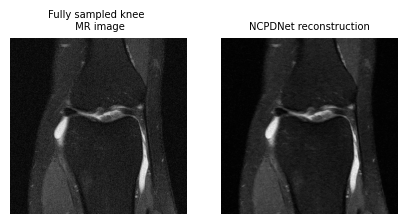

In [29]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(ncpdnet_reconstructed_image[0, ..., 0])
axs[1].set_title('NCPDNet reconstruction')
for i in [0, 1]:
    axs[i].axis('off');

In [30]:
print('PSNR of the NCPDNet reconstructed image:', psnr(image, ncpdnet_reconstructed_image[0]/1e6))

PSNR of the NCPDNet reconstructed image: 29.526865665679534


In [31]:
print('SSIM of the NCPDNet reconstructed image:', ssim(image[None, ..., 0], ncpdnet_reconstructed_image[..., 0]/1e6))

SSIM of the NCPDNet reconstructed image: 0.6307442


As a comparison this is better than what is achieved by the UPDNet for the same acceleration factor despite a much deeper image subnetwork (see the [intro notebook](mri_reconstruction_intro.ipynb)).